In [1]:
import os
import copy
import numpy as np
from scipy import signal, stats, constants
from scipy.optimize import minimize, curve_fit
from scipy.interpolate import CubicSpline
import h5py as hp
import pandas as pd
import math

import datetime

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

To install PyMC _properly_ on Windows, follow: https://github.com/pymc-devs/pymc/issues/4937

In [2]:
import arviz as az
import pymc3 as pm
import theano.tensor as tt
print(f"Running on PyMC v{pm.__version__}")

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.


Running on PyMC v3.11.6


### Setup

## Geometry definition

<IPython.core.display.Javascript object>


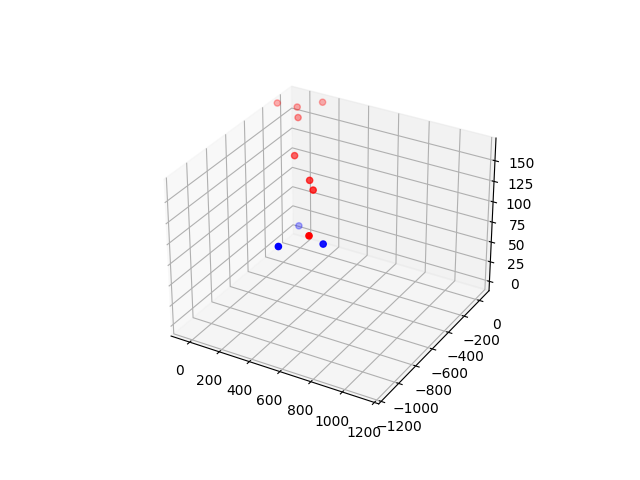

Beacon 3008 at [-6.62954633e+01 -1.47584719e+02  1.18540950e-10]
Beacon 2404 at [-8.86432006e+01  1.33207760e+02  1.18657466e-10]
Beacon 2407 at [1.54938664e+02 1.43769586e+01 1.18502957e-10]


In [3]:
test_locations = np.load("rotated_test_locations.npy", allow_pickle=True)
beacon_locations = np.load("rotated_beacons.npy", allow_pickle=True)

beacon_labels = ["3008", "2404", "2407"]

TAT = np.array([0.24, 0.44, 0.64])

%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(test_locations[0], test_locations[1], test_locations[2], color='red')
ax.scatter(beacon_locations[0], beacon_locations[1], beacon_locations[2], color='blue')
ax.set_xlim((-100,1200))
ax.set_ylim((-1200,100))

#beacon_locations[:,[1,2]] = beacon_locations[:,[2,1]]
beacon_locations = beacon_locations[:,[1,2,0]]

print(f"Beacon 3008 at {beacon_locations[:,0]}")
print(f"Beacon 2404 at {beacon_locations[:,1]}")
print(f"Beacon 2407 at {beacon_locations[:,2]}")

In [4]:
d0   = 200. # m

beacons = {'test'   : [[0, 0],
                       [0, 100.],
                       [0, 0]],
           'minimal': [[0, d0, d0],
                       [0, d0, -d0],
                       [0, 0, 0]],
           # 'extend' : [[0, d0, d0, -d0, -d0],
           #             [0, d0, -d0, d0, -d0],
           #             [0, 0, 0, 0, 0]],
           # 'p-one'  : [[12.3, 36.9, 62.3, 37.2, -12.7, -37.2, -12.7],
           #             [-21.3, -64.6, -21, 21.9, 21.9, -21.9, -62.3],
           #             [0, 0, 0, 0, 0, 0, 0]],
            }

receiver = np.array([[110],
                     [50],
                     [150]])

for key in beacons:
    beacons[key] = np.array(beacons[key], dtype=float)
    
for key in beacons:
    x, y, z    = beacons[key]
    xr, yr, zr = receiver
    dist       = np.sqrt((x-xr)**2 + (y-yr)**2 + (z-zr)**2)
    print('%s %s' %(key, dist))
    
print(receiver.shape)

test [192.61360284 192.61360284]
minimal [192.61360284 230.43437244 305.12292605]
(3, 1)


<IPython.core.display.Javascript object>


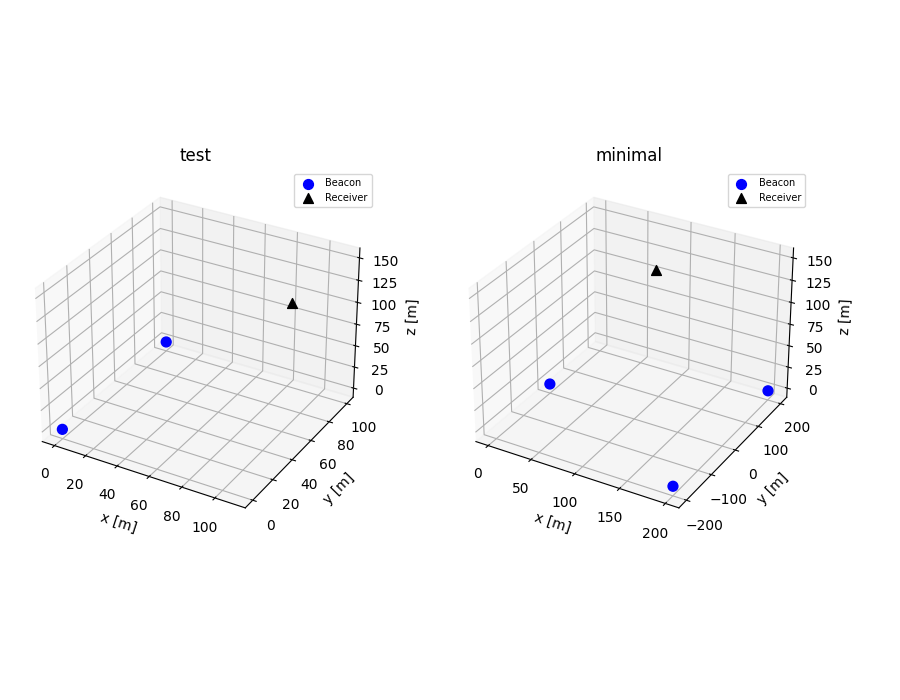

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9,7), subplot_kw={'projection': '3d'})
axs = axs.flatten()

nb = len(beacons)

# draw beacons
for i, key in enumerate(beacons):
    
    x, y, z = beacons[key]
    
    # draw beacons
    axs[i].scatter(x, y, z, marker='o', color='blue', s=50, alpha=1, label='Beacon')
    
    # draw receivers
    x, y, z = receiver
    axs[i].scatter(x, y, z, marker='^', color='black', s=50, label='Receiver')
        
    # format
    axs[i].set_title(key)
    axs[i].set_xlabel('x [m]')
    axs[i].set_ylabel('y [m]')
    axs[i].set_zlabel('z [m]')
    axs[i].legend(loc='upper right', fontsize=7)
    # axs[i].view_init(90, 90)

plt.tight_layout()
plt.subplots_adjust(wspace=0.2, right=0.9)
plt.show()

## Priors, parameter uncertainties

**ONC beacon position**

$x_i = x_{0,i}  \pm  2 \,$m in ( 𝑥 ,  𝑦 ,  𝑧 )

---

**Speed of sound**  

$v_s = 1520  \pm  20 \,\frac{m}{s}$ [1]

[1] Saanich profiler data

---

**Resolution**

$\sigma_{spatial} \approx 15 \, \mu s \sim$ Piezo size [2]

$\sigma_{ADC} \approx 1.5 \, \mu s \sim$  ADC sampling at $768\,\text{kHz}$

$\sigma_{sync} \approx 5 \, \mu s \sim$  Synchronization

$\sigma_{Shannon} = 1\,\text{bit} \, / \left( \frac{1}{t_{recording}} \cdot \sum_\omega \log_2 \left( 1 + \text{SNR}(\omega) \right) \right) \approx 10 - 100\,\mu s$ [2]

[2] https://www.institut3b.physik.rwth-aachen.de/global/show_document.asp?id=aaaaaaaaatmdetx

Assuming all resolutions affect the arrival time measurement independently, and roughly follow a Gaussian distribution, we have

$ \sigma_{total} = \sqrt{ \sum_i \sigma_i^2 } \approx \begin{cases} 17.2\;\mu s \quad \sigma_{shannon} = 10\, \mu s\\ 101\;\mu s \quad \sigma_{shannon} = 100\, \mu s\end{cases} $

In [5]:
# speed of sound
c0  = 1492 # m/s
d_c0 = 5 # m/s

# acoustic resolutions
# taken from: https://www.institut3b.physik.rwth-aachen.de/global/show_document.asp?id=aaaaaaaaatmdetx
# especially Table 4.1, Figure 4.5
d_spatial = 13e-6 # us
d_adc = 1.5e-6 # us
d_sync = 5e-6 # us
d_shannon = 100e-6 # us
# this is an estimate based on longest attenuation length in ice = 300m
# in water: http://resource.npl.co.uk/acoustics/techguides/seaabsorption/ (F=15, T=3, D=2.5, S=35, pH=8)
# gives sound absorption, a, within [1.392, 1.706] db/km
# in 1/km this becomes a' = a * (ln(10)/10)
# for a = 1.5 db/km --> attenuation length = 1 / a' = 1 / (a * (ln(10)/10)) = 2.8km ~ 10 * attenuation length ice
# so we use d_shannon ~ d_shannon_icecube / 10
d_t = np.sqrt(d_spatial**2 + d_adc**2 + d_sync**2 + d_shannon**2)

# beacon placement accuracy
d_beacon = 10. # m

## Minimization scheme

Minimize the following function

$\chi^2 = \frac{\sum_i \left( t_i - \left( \frac{\sqrt{(x-x_i)^2 + (y-y_i)^2 + (z-z_i)^2}}{v_s}\right)\right)^2}{\Delta t^2 \cdot N_{beacon}}$

where $x_i, y_i, z_i$ are the coordinates of the beacons, $x,y,z$ are the coordinates of the receiver, $t_i$ is the nominal time of flight, $v$ is the speed of sound in water, $\Delta t$ the nominal time error, and $N_{beacon}$ the number of used beacons.

$x_i, y_i, z_i, v_s, t_i$ are varied according to the Markov method and their proposed uncertainties.

$x, y, z$ are fit.

In [40]:
def calc_distances(coords, receiver=receiver):
    x, y, z    = copy.deepcopy(coords)
    xr, yr, zr = receiver
    dist       = np.sqrt((x-xr)**2 + (y-yr)**2 + (z-zr)**2)
    return dist

def calc_times(coords, receiver=receiver):
    t0 = distances(coords, receiver=receiver) / c0
    return t0

In [5]:
def gaussian(x, a, mu, sig):
    return a * np.exp(-(x-mu)**2/(2*sig**2))

def fit_gaussian(x, bins=100, r=(), sigma=0.1, tol=0.):
    n, e = np.histogram(x, range=r, bins=bins)
    c    = (e[:-1] + e[1:]) / 2.
    a0   = np.max(n)
    mu0  = c[(n == np.max(n))][0]
    sig0 = sigma
    m = (n >= tol*n)
    popt, pcov = curve_fit(gaussian, c[m], n[m], p0=(a0, mu0, sig0), maxfev=10000)
    return popt

In [6]:
def ctxyz(coords, d_t=d_t, d_c0=d_c0, d_beacon_xy=d_beacon, d_beacon_z=d_beacon):
    x,y,z    = copy.deepcopy(coords)
    dt      = np.random.normal(loc=0, scale=d_t)
    c       = c0 + np.random.normal(loc=0, scale=d_c0)
    x       += np.random.normal(loc=0, scale=d_beacon_xy,  size=x.shape)
    y       += np.random.normal(loc=0, scale=d_beacon_xy,  size=y.shape)
    z       += np.random.normal(loc=0, scale=d_beacon_z,  size=z.shape)
    return c, dt, np.array([x,y,z])

def chi2(p, w_coords, w_c, w_dt, r0):
    xi, yi, zi = p
    x, y, z = copy.deepcopy(w_coords)
    n_b     = len(x)
    r       = np.sqrt((x-xi)**2 + (y-yi)**2 + (z-zi)**2)
    t       = r/w_c
    t0      = r0/c0 + w_dt
    dt2     = (t - t0)**2
    chi2    = np.sum(dt2/(d_t**2 * n_b))
    return chi2

---

# MCMC sampling

Open questions after Technical Call

* Check how known string self-position changes things

* Check inter-module precision by fitting two receivers at once

**Strategy to target both:** Simultaneously fit all beacon positions at once while using their uncertainty priors. This should constrain the geometry better than iterative fitting of each beacon alone because it uses the whole beacon geometry information at once.

**Keep in mind:** Need to vectorize as much as possible to speed up sampler.

## Likelihood

Minimize the function from above

$\chi^2 = \frac{\sum_i \left( t_i - \left( \frac{\sqrt{(x-x_i)^2 + (y-y_i)^2 + (z-z_i)^2}}{v_s}\right)\right)^2}{\Delta t^2 \cdot N_{beacon}}$

where $x_i, y_i, z_i$ are the coordinates of the beacons, $x,y,z$ are the coordinates of the receiver, $t_i$ is the nominal time of flight, $v$ is the speed of sound in water, $\Delta t$ the nominal time error, and $N_{beacon}$ the number of used beacons.

$x_i, y_i, z_i, v_s, t_i$ are varied according to the Markov method and their proposed uncertainties.

All beacon and receiver $x, y, z$ coordinates are fit.

For a custom likelihood can be defined in PyMC follow: https://discourse.pymc.io/t/how-to-set-up-a-custom-likelihood-function-for-two-variables/906/6

In [3]:
def load_p1(inp_p1):
    # [fi, ch, id_p, t, toa_p[0] - toa_i1]
    p1    = np.load(inp_p1, allow_pickle=True) 
    df_p1 = pd.DataFrame({'file_index' : p1[:,0],
                          'channel'    : p1[:,1],
                          'id'         : p1[:,2],
                          'utc_time'   : p1[:,3],
                          'tof'        : p1[:,4]})
    return df_p1

In [4]:
def datetime_to_radians(x):
    # radians are calculated using a 24-hour circle, not 12-hour, starting at north and moving clockwise
    if type(x) == datetime.time:
        time_of_day = x
    else:
        time_of_day = x.time()
    seconds_from_midnight = 3600 * time_of_day.hour + 60 * time_of_day.minute + time_of_day.second
    radians = float(seconds_from_midnight) / float(12 * 60 * 60) * 2.0 * math.pi
    return radians

def average_angle(angles):
    # angles measured in radians
    x_sum = np.sum([math.sin(x) for x in angles])
    y_sum = np.sum([math.cos(x) for x in angles])
    x_mean = x_sum / float(len(angles))
    y_mean = y_sum / float(len(angles))
    return np.arctan2(x_mean, y_mean)

def radians_to_time_of_day(x):
    # radians are measured clockwise from north and represent time in a 24-hour circle
    seconds_from_midnight = int(float(x) / (2.0 * math.pi) * 12.0 * 60.0 * 60.0)
    hour = (seconds_from_midnight // 3600) % 24
    minute = (seconds_from_midnight % 3600) // 60
    second = seconds_from_midnight % 60
    return datetime.time(hour, minute, second)

def average_times_of_day(x):
    # input datetime.datetime array and output datetime.time value
    angles = [datetime_to_radians(y) for y in x]
    avg_angle = average_angle(angles)
    return radians_to_time_of_day(avg_angle)

In [57]:
# Load in Boat Data
data_file = '/home/dilraj/Programs/ocean_test/data/rev4/ANALYSIS/SAANICH/tof-loc1.pkl'
boat_data = pd.read_pickle(data_file)
#data_file = '/home/dilraj/Programs/ocean_test/data/rev4/ANALYSIS/SAANICH/tof.npy'
#boat_data = load_p1(data_file)

sample_boat_data = boat_data.loc[:, ['id', 'tof', 'utc_time', 'channel']] #boat_data.loc[2:4, ['id', 'tof', 'utc_time']]
# 366:368 # 241:243 10:12
print(sample_boat_data)

       id       tof                         utc_time channel
0    3008  0.528712 2024-08-07 18:34:19.647057+00:00       1
1    2404   0.72109 2024-08-07 18:34:19.839435+00:00       1
2    3008  0.528546 2024-08-07 18:34:22.656578+00:00       1
3    2404  0.739872 2024-08-07 18:34:22.867904+00:00       1
4    2407  0.922042 2024-08-07 18:34:23.050074+00:00       1
..    ...       ...                              ...     ...
227  3008  0.529965 2024-08-07 18:37:56.862298+00:00       4
228  2404  0.719268 2024-08-07 18:37:57.051601+00:00       4
229  2407  0.921371 2024-08-07 18:37:57.253704+00:00       4
230  3008  0.531058 2024-08-07 18:37:59.984703+00:00       4
231  2407  0.790203 2024-08-07 18:38:00.243849+00:00       4

[232 rows x 4 columns]


In [55]:
# Load in Sonardyne Data
sonardyne_file = '/home/dilraj/Programs/ocean_test/data/rev4/ANALYSIS/SAANICH/df-sonardyne-log.pkl'
sonardyne_data = pd.read_pickle(sonardyne_file)

#print(sonardyne_data.keys())

sonardyne_LOC = sonardyne_data#.loc[lambda df: df['Location'] == 'LOC7',:] #['R3008', 'R2404', 'R2407']
#sonardyne_LOC = sonardyne_LOC.loc[lambda df: df['R3008'] == df['R3008'], :]

#sonardyne_LOC1_tof_means = sonardyne_LOC1.mean()

sample_sonardyne_data = sonardyne_LOC.loc[92] #[84] -> 18:34:22 UTC   [222] -> 18:37:57 UTC
# [1557] -> 22:01:59 UTC [1712] -> 22:06:33 UTC  [1393] -> 21:49:49 UTC [1547] -> 21:54:45 

print(sample_sonardyne_data)

Datetime                                  2024-08-07 18:34:34
Log         2024-08-07 6:34:34 PM.601,>MSR:IR3008;R542948[...
R3008                                                542948.0
R2404                                                734301.0
R2407                                                932940.0
Location                                                 LOC1
Name: 92, dtype: object


In [48]:
beacon_labels = {                                                                                                                                         
        "R3008":0,                                                                                                                                            
        "R2404":1,                                                                                                                                            
        "R2407":2                                                                                                                                             
        }                                                                                                                                                     
TAT = np.array([0.24, 0.44, 0.64])
index_list_sonardyne = [84, 222, 1393, 1547, 1563, 1712]
for i in range(6):
    data = sonardyne_LOC.loc[index_list_sonardyne[i]]
    ids = ['R3008', 'R2404', 'R2407']
    sonardyne_tof = (data[ids].to_numpy().astype(float))*1e-6
    beacon_indices = [beacon_labels[x] for x in ids]
    times = (sonardyne_tof - TAT)/2 #(sonardyne_tof - TAT[beacon_indices])/2 
    print(times)

[0.151939 0.146766 0.146369]
[0.150632  0.1470305 0.1477805]
[0.6403095 0.7888235 0.6428585]
[0.6374655 0.787553  0.642898 ]
[0.952231 1.108771 0.964369]
[0.9615275 1.118991  0.975396 ]


In [139]:
# find all sets of ['3008', '2404','2407']
ids = boat_data.loc[:,['id']].to_numpy().astype('str')

first_indices = np.array(np.where(ids == '3008'))
second_indices = first_indices[0] + 1
first_indices = np.array([x for x in second_indices if ids[x] == '2404'])
second_indices = first_indices + 1
first_indices = [x for x in second_indices if ids[x] == '2407']

final_indices = [[x-2, x-1, x] for x in first_indices]
final_indices = np.array(final_indices)

In [149]:
times = boat_data.loc[0:2, ['utc_time']].to_numpy()
times = [x[0].to_pydatetime() for x in times]

average_time = average_times_of_day(times)

times_sonardyne = sonardyne_LOC.loc[:, ['Datetime']].to_numpy()
times_sonardyne = [pd.Timestamp(x[0]).to_pydatetime() for x in times_sonardyne]
times_sonardyne_radians = np.array([datetime_to_radians(x) for x in times_sonardyne])
average_time_radian = datetime_to_radians(average_time)

index_choice = np.argmin(times_sonardyne_radians - average_time_radian)
true_index = sonardyne_LOC.index[index_choice]
print(true_index)

1557


In [141]:
times_sonardyne = sonardyne_LOC.loc[:, ['Datetime']].to_numpy()
times_sonardyne = [pd.Timestamp(x[0]).to_pydatetime() for x in times_sonardyne]
times_sonardyne_radians = np.array([datetime_to_radians(x) for x in times_sonardyne])

sonardyne_corresponding_indices = np.ones(len(final_indices))*-1

for i, indices in enumerate(final_indices):
    times = boat_data.loc[indices, ['utc_time']].to_numpy()
    times = [x[0].to_pydatetime() for x in times]
    average_time = average_times_of_day(times)
    average_time_radian = datetime_to_radians(average_time)
    index_choice = np.argmin(np.abs(times_sonardyne_radians - average_time_radian))
    sonardyne_corresponding_indices[i] = index_choice

print(sonardyne_corresponding_indices)
sonardyne_corresponding_indices = np.array(sonardyne_corresponding_indices)

[ 0.  3.  3.  4.  5.  7.  7.  8.  0.  3.  3.  4.  5.  7.  7.  8. 11. 12.
 13. 14. 15. 16. 17. 17. 18. 11. 12. 13. 14. 15. 16. 17. 17. 18. 22. 23.
 24. 24. 26. 26. 27. 22. 23. 24. 24. 26. 26. 27. 30. 32. 33. 34. 35. 36.
 37. 38. 30. 32. 33. 34. 35. 36. 37. 45. 41. 41. 59. 53. 55. 57. 58. 59.
 61. 62. 63. 65. 66. 67. 68. 62. 63. 65. 66. 67. 68. 69. 70. 71. 73. 74.
 76. 76. 77. 69. 70. 71. 73. 74. 76. 76. 77.]


In [142]:
# save sonardyne corresponding indices and sets of beacon indices

a = hp.File('/home/dilraj/Programs/ocean_test/data/rev4/ANALYSIS/SAANICH/sonardyne_corresponding_times.hdf5', 'w')
a['sonardyne_corresponding_indices'] = sonardyne_corresponding_indices
a['paired_beacons_indices'] = final_indices
a.close()

In [45]:
# Load in distance correction
bellhop_correction_file = '/home/dilraj/Programs/ocean_test/data/rev4/ANALYSIS/SAANICH/df-bellhop-corrections.pkl'
bellhop_correction = pd.read_pickle(bellhop_correction_file)

#print(bellhop_correction.keys())
#print(bellhop_correction.loc[:,['rx_r', 'distance']])

bellhop_correction = bellhop_correction.loc[lambda df: df['rx_d'] == 20,:]
bellhop_correction = bellhop_correction.loc[:, ['distance', 'corr_median']]

fit_distance = bellhop_correction['distance'].to_numpy().astype(float)
t_correction = bellhop_correction['corr_median'].to_numpy().astype(float)

spline_fit = CubicSpline(fit_distance, t_correction)
    
a = tt.zeros((2,3))

def func_test(value):
    returns 2*value + 1
    
b = tt.function()

Alloc.0


In [10]:
measured_times = sample_boat_data['tof'].to_numpy().astype(float)
sonardyne_TOF = (sample_sonardyne_data[['R3008', 'R2404', 'R2407']].to_numpy().astype(float))*1e-6

sonardyne_one_way = (sonardyne_TOF - TAT)/2
# Boat Time Comparison

print(measured_times)
print(sonardyne_one_way)

t = measured_times - TAT - sonardyne_one_way + 8/c0
print(t)

[2.12968666 2.64337215 2.55430165]
[0.9518835 1.1084095 0.96398  ]
[0.94316509 1.10032458 0.95568358]


In [19]:
print(f'R3008 {sample_boat_data["tof"][2] - sample_sonardyne_data["R3008"]*1e-6}')
print(f'R2404 {sample_boat_data["tof"][3] - sample_sonardyne_data["R2404"]*1e-6}')
print(f'R3008 {sample_boat_data["tof"][4] - sample_sonardyne_data["R2407"]*1e-6}')

R3008 -0.015331810487490771
R2404 0.0063400100517213565
R3008 -0.010695606653108647


The distance calculation needs to be modified to account for the fact that our receiver sits below the interrogator. So the $t_{i}$ tof that is observed in the acoustic receivers will actually be $t_{\text{PM}} + t_{\text{PI}} + t_{\text{TAT}} - h/v_{s}$, where 'P' is the deployed beacon, 'M' is the receiving module, and 'I' is the interrogator. 

The algorithim expects to get a time $t_{\text{PM}}$, so then 

$$ t_{\text{PM}} = t_{i} - t_{\text{PI}} - t_{\text{TAT}} + h/v_{s} . $$

Taking 'P' at $\vec{r}_{\text{P}}$, 'M' at $\vec{r}_{\text{M}}$, and $h$ being the height that the receiver is below the Interrogator, we get

$$ t_{\text{PM}} = t_{i} - \frac{|\vec{r}_{\text{P}} - \vec{r}_{\text{M}} - h\hat{z}|}{v_{s}} - t_{\text{TAT}} + \frac{h}{v_{s}} $$.

In [32]:
### set data   
X_B   = beacon_locations
X_R   = np.array([[test_locations[0,0]], [test_locations[1,0]], [test_locations[2,0] - 20]])
D     = np.linalg.norm(X_R.T - X_B.reshape(3,-1).T[:,None], axis=-1)
Y     = measured_times #D / c0
#TAT   = np.array([0.24, 0.44, 0.64])
#h     = 15 # meters

# set up position uncertainties
DX_B  = np.full(X_B.shape, d_beacon)
DX_R  = np.full(X_R.shape, d_beacon)
#DX_R[2] = 1.0 # z-direction much more constrained

# calculate number of beacons, receivers
n_b = X_B.shape[1]
n_r = X_R.shape[1]

labels = ['X_B', 'X_R', 'DX_B', 'DX_R', 'D', 'Y']
for i, arr in enumerate([X_B, X_R, DX_B, DX_R, D, Y]):
    print(labels[i], arr.shape)

# setup PyMC model object
model = pm.Model()
with model:
    
    # priors for unknown model parameters
    vs = pm.Normal('vs', mu=c0, sigma=d_c0)
#    xb = pm.Normal('xb', mu=X_B, sigma=DX_B, shape=X_B.shape)
#    xr = pm.Normal('xr', mu=X_R, sigma=DX_R, shape=X_R.shape)
    h  = pm.Uniform('h', lower=0, upper=20, shape=(1,)) #mu=h_guess, sigma=8, 
    xb = pm.Uniform('xb', lower=X_B-DX_B, upper=X_B+DX_B, shape=X_B.shape)
    xr = pm.Uniform('xr', lower=X_R-DX_R, upper=X_R+DX_R, shape=X_R.shape)
    
    # calculate distances
    d = tt.zeros((n_b, n_r))
    for i in range(n_b):
        for j in range(n_r):
            dist = tt.sqrt(tt.sum( tt.square(xb[:,i] - xr[:,j]) ))
            d = tt.set_subtensor(d[i,j], dist)
    pm.Deterministic('d', d)

    # expected value of outcome
    mu = d/vs
    
    # extract Recevier-Beacon Time from measured times based on predicted position
    #shift = tt.sqrt(tt.sum(tt.square(xb[:,i] - xr[:,j] - np.array([0,0,h]))))/vs
    # Use the provided Sonardyne TOF
    
    t = Y - sonardyne_one_way - TAT + h/vs 
    
    print(t)

    # likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=d_t*np.sqrt(n_b), observed=t)
    
    # sample
    sample = pm.sample(10000, step = pm.step_methods.DEMetropolis())

X_B (3, 3)
X_R (3, 1)
DX_B (3, 3)
DX_R (3, 1)
D (3, 1)
Y (3,)
Elemwise{add,no_inplace}.0


The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
Population sampling (4 chains)
DEMetropolis: [xr, xb, h, vs]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Sampling 4 chains for 0 tune and 11_000 draw iterations (0 + 44_000 draws total) took 11 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [136]:
# SONARDYNE Data

### set data   
X_B   = beacon_locations
X_R   = np.array([[test_locations[0,0]], [test_locations[1,0]], [test_locations[2,0] - 12]])
D     = np.linalg.norm(X_R.T - X_B.reshape(3,-1).T[:,None], axis=-1)
Y     = sonardyne_one_way #D / c0

# set up position uncertainties
DX_B  = np.full(X_B.shape, d_beacon)
DX_R  = np.full(X_R.shape, d_beacon)
#DX_R[2] = 1.0 # z-direction much more constrained

# calculate number of beacons, receivers
n_b = X_B.shape[1]
n_r = X_R.shape[1]

labels = ['X_B', 'X_R', 'DX_B', 'DX_R', 'D', 'Y']
for i, arr in enumerate([X_B, X_R, DX_B, DX_R, D, Y]):
    print(labels[i], arr.shape)

# setup PyMC model object
model = pm.Model()
with model:
    
    # priors for unknown model parameters
    vs = pm.Normal('vs', mu=c0, sigma=d_c0)
    xb = pm.Normal('xb', mu=X_B, sigma=DX_B, shape=X_B.shape)
    xr = pm.Normal('xr', mu=X_R, sigma=DX_R, shape=X_R.shape)
#    xb = pm.Uniform('xb', lower=X_B-DX_B, upper=X_B+DX_B, shape=X_B.shape)
#    xr = pm.Uniform('xr', lower=X_R-DX_R, upper=X_R+DX_R, shape=X_R.shape)
    
    # calculate distances
    d = tt.zeros((n_b, n_r))
    for i in range(n_b):
        for j in range(n_r):
            dist = tt.sqrt(tt.sum( tt.square(xb[:,i] - xr[:,j]) ))
            d = tt.set_subtensor(d[i,j], dist)
    pm.Deterministic('d', d)

    # expected value of outcome
    mu = d/vs
    
    # likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=d_t*np.sqrt(n_b), observed=Y)
    
    # sample
    sample = pm.sample(1000) #, step = pm.step_methods.DEMetropolisZ())

The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.


X_B (3, 3)
X_R (3, 1)
DX_B (3, 3)
DX_R (3, 1)
D (3, 1)
Y (3,)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [xr, xb, vs]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


<IPython.core.display.Javascript object>


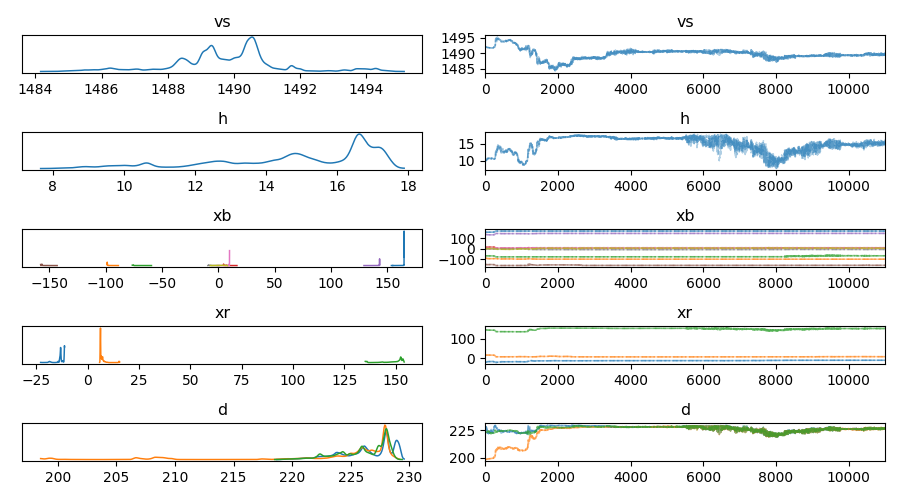

In [33]:
with model:    
    # output
    az.plot_trace(sample, combined=True, figsize=(9,5))
    plt.tight_layout()
    plt.show()

In [45]:
a = az.summary(sample, round_to=2)
a
#a.loc[lambda df: df[''] == 'LOC1',:]

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
vs,1489.75,1.66,1484.83,1492.26,0.25,0.18,41.34,82.61,1.16
h[0],14.86,2.27,10.29,17.60,0.37,0.28,35.70,161.40,1.07
"xb[0, 0]",164.57,1.58,164.65,164.91,0.14,0.10,40.87,76.18,1.25
"xb[0, 1]",-97.96,1.34,-98.60,-95.52,0.24,0.17,11.88,69.79,1.27
"xb[0, 2]",-73.23,4.13,-76.26,-65.10,0.99,0.72,8.02,98.98,1.46
"xb[1, 0]",5.85,1.93,4.43,7.66,0.25,0.18,24.71,163.66,1.14
"xb[1, 1]",142.54,1.96,141.10,143.15,0.27,0.20,26.25,94.92,1.38
"xb[1, 2]",-155.69,2.09,-157.58,-151.04,0.25,0.18,89.69,107.82,1.02
"xb[2, 0]",9.51,1.53,7.84,10.00,0.20,0.17,36.52,85.59,1.06
"xb[2, 1]",-7.37,1.90,-9.03,-3.32,0.32,0.24,29.34,159.13,1.00


Indexing works as follows

x[0,0] = x coordinate of first beacon

x[0,N-1] = x coordinate of Nth receiver

...

x[1,0] = y coordinate of first receiver

x[1,N-1] = y coordinate of Nth receiver

...

x[2,1] = z coordinate of second receiver

x[2,N-1] = z coordinate of Nth receiver

In [50]:
a.index.to_list()

['vs',
 'h[0]',
 'xb[0, 0]',
 'xb[0, 1]',
 'xb[0, 2]',
 'xb[1, 0]',
 'xb[1, 1]',
 'xb[1, 2]',
 'xb[2, 0]',
 'xb[2, 1]',
 'xb[2, 2]',
 'xr[0, 0]',
 'xr[1, 0]',
 'xr[2, 0]',
 'd[0, 0]',
 'd[1, 0]',
 'd[2, 0]']

In [22]:
def multiple_arrays(sample, var_names=[]):
    a = copy.deepcopy(sample[var_names[0]])
    n = a.shape[0]
    a = a.reshape(n, -1)
    for key in var_names[1:]:
        _a = sample[key].reshape(n, -1)
        a  = np.concatenate((a, _a), axis=1)
    return a

<IPython.core.display.Javascript object>


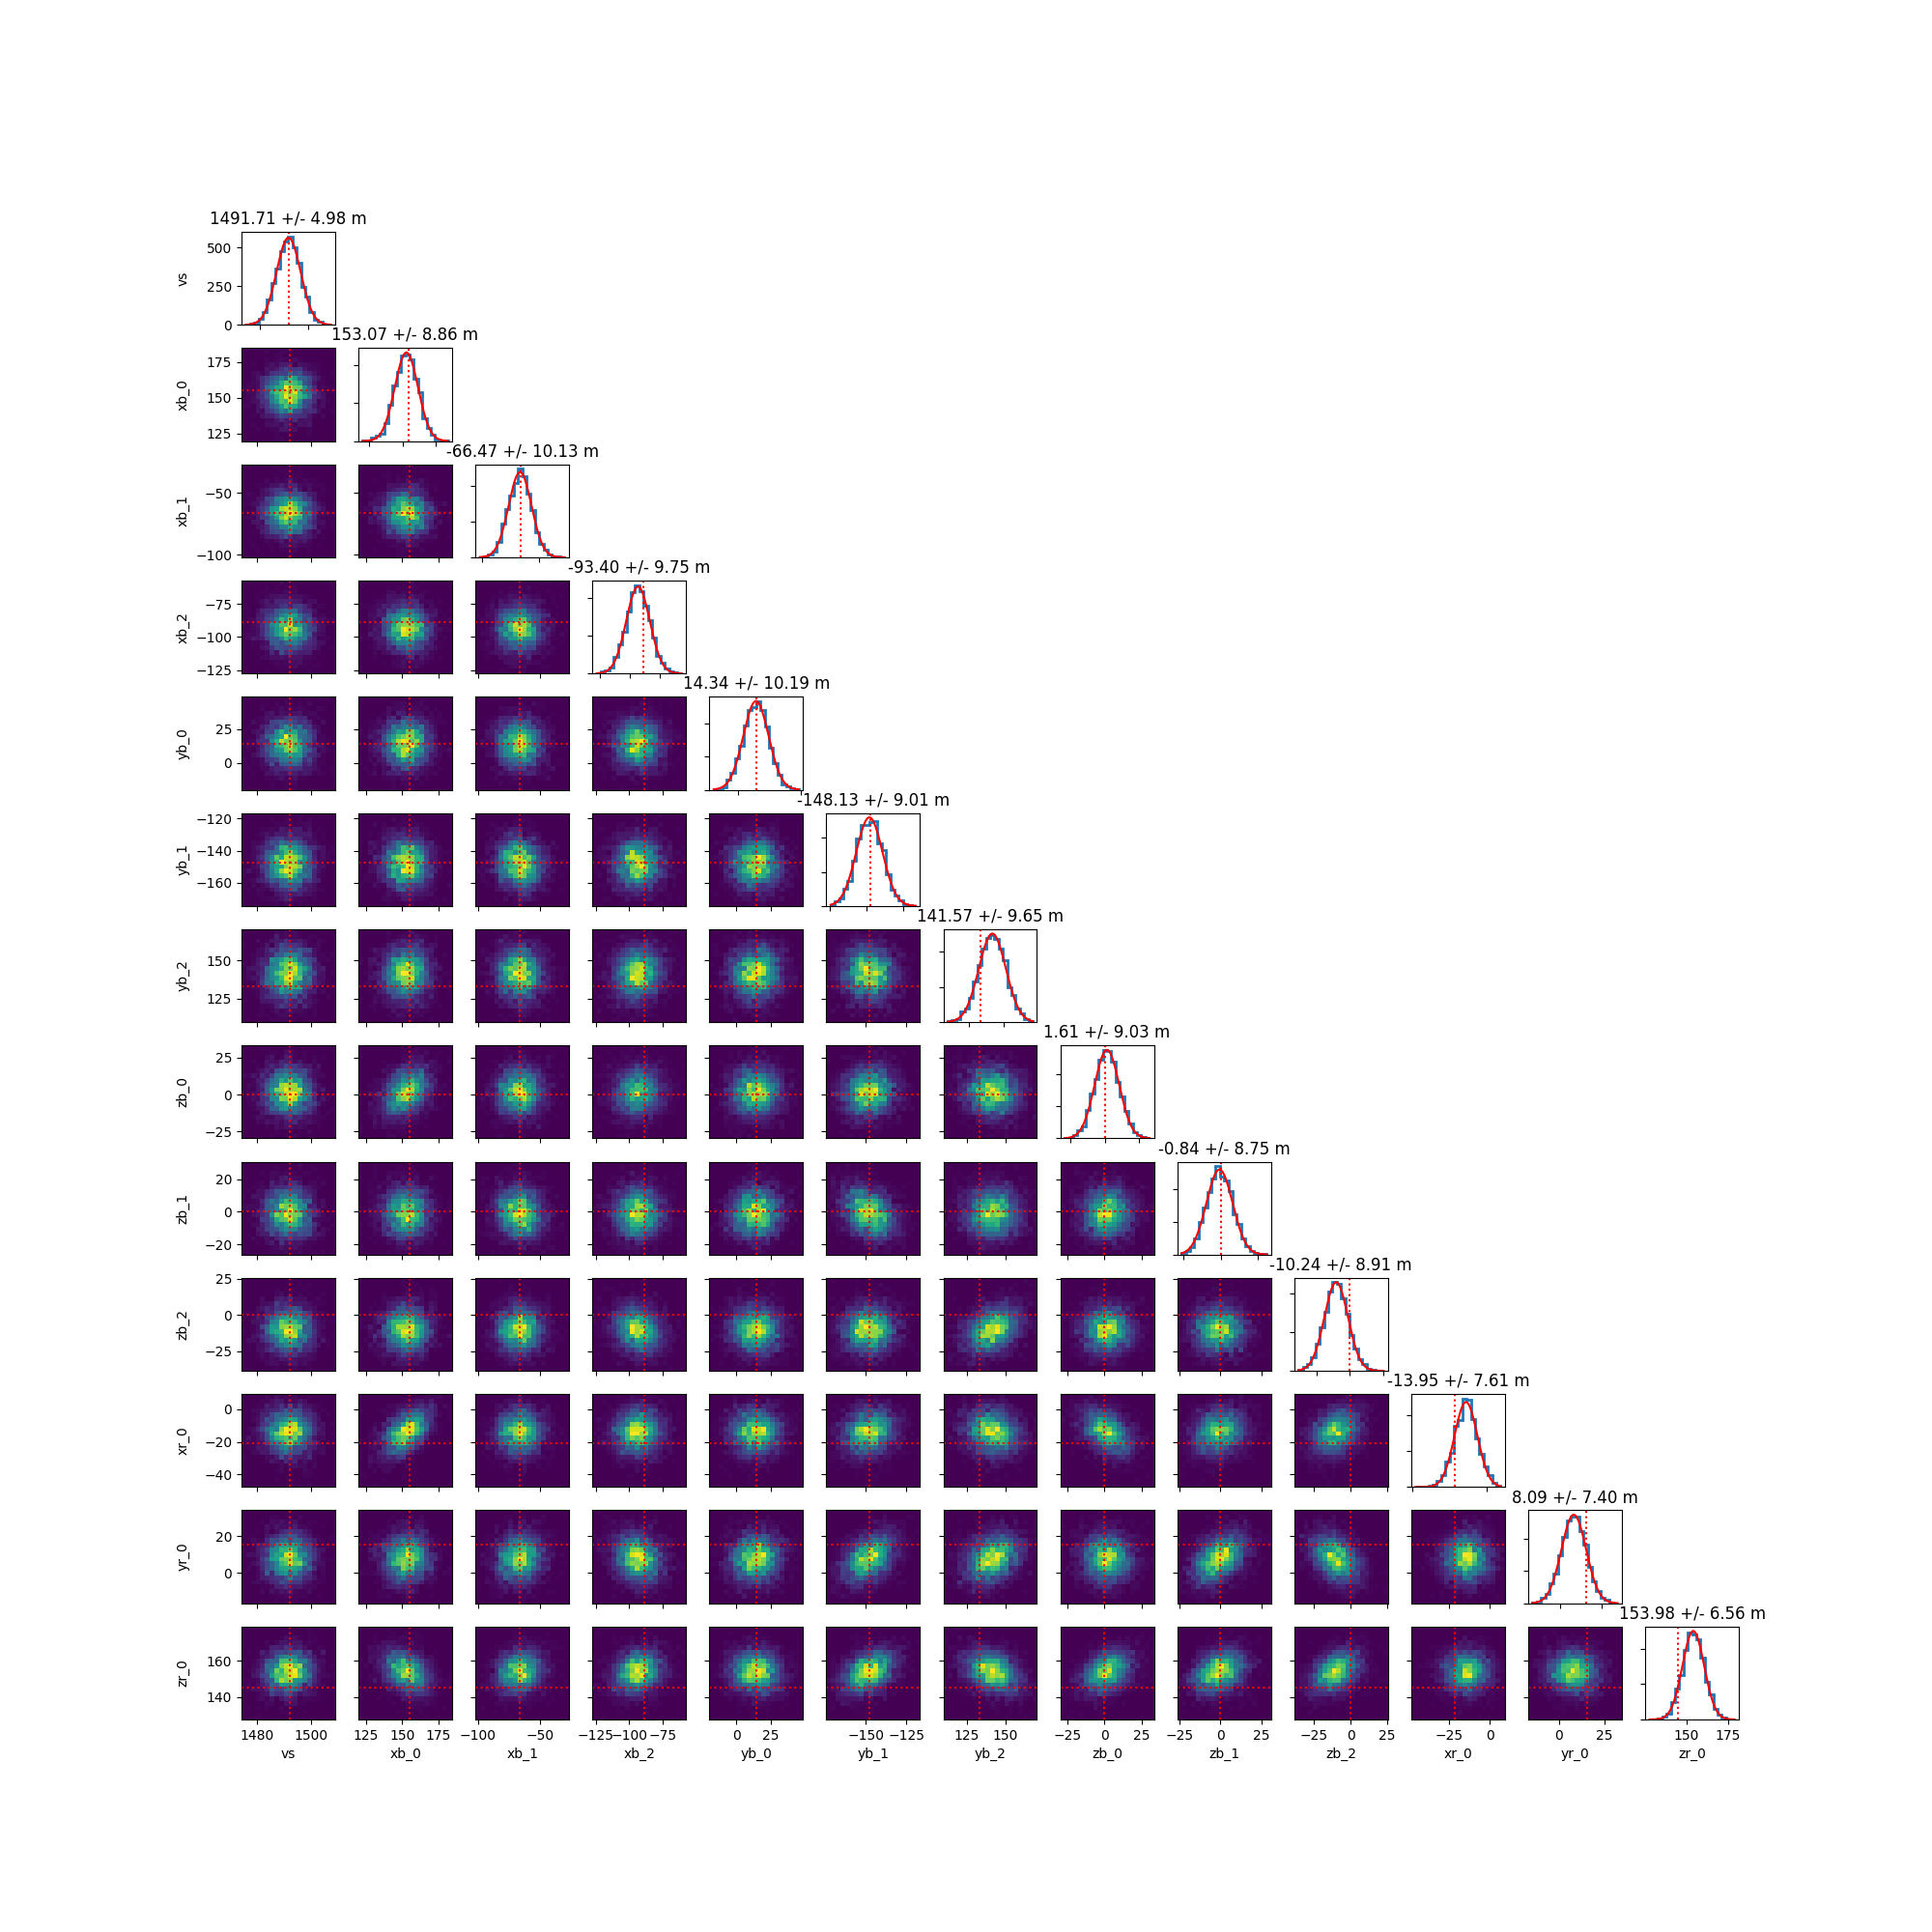

In [46]:
chain  = multiple_arrays(sample, var_names=['vs', 'xb', 'xr'])
ndim   = chain.shape[1] 
bins   = 20
trth   = np.concatenate(([c0], X_B.flatten(), X_R.flatten()))
lbls   = ['vs'] + ['xb_%i' %(i) for i, rec in enumerate(X_B.flatten()[::3])]  \
                + ['yb_%i' %(i) for i, rec in enumerate(X_B.flatten()[1::3])] \
                + ['zb_%i' %(i) for i, rec in enumerate(X_B.flatten()[2::3])] \
                + ['xr_%i' %(i) for i, rec in enumerate(X_R.flatten()[::3])]  \
                + ['yr_%i' %(i) for i, rec in enumerate(X_R.flatten()[1::3])] \
                + ['zr_%i' %(i) for i, rec in enumerate(X_R.flatten()[2::3])]

fs   = 20
fig  = plt.figure(figsize=(fs, fs))
gs   = fig.add_gridspec(ndim, ndim, hspace=0.25, wspace=0.25)

for i in range(ndim):
               
    for j in range(ndim):
        
        if j <= i:
            ax = fig.add_subplot(gs[i:i+1, j:j+1])
            
        # plot hist
        if i == j:
            # truths
            ax.axvline(trth[i], color='red', ls=':')
            # mcmc hist
            x    = chain[:,i]
            n, e = np.histogram(x, bins=bins)
            # fit
            xfit = np.linspace(x.min(), x.max(), 10000)
            popt = fit_gaussian(x, bins=bins, r=(x.min(), x.max()), sigma=1.1)
            # plot
            ax.stairs(n, e, lw=2)
            ax.plot(xfit, gaussian(xfit, *popt), color='red')
            # title
            ax.set_title('%.2f +/- %.2f m' %(popt[1], popt[2]))
            
        # plot scatter
        if i > j:
            # truths
            ax.scatter(trth[j], trth[i], marker='x', color='red')
            ax.axvline(trth[j], color='red', ls=':')
            ax.axhline(trth[i], color='red', ls=':')
            H, yedges, xedges = np.histogram2d(chain[:,i], chain[:,j], bins=bins
                                              )
            ax.pcolormesh(xedges, yedges, H)
            
        if i > 0 and j > 0:
            ax.tick_params(axis='y', which='both', labelleft=False)
            
        if i < ndim-1:
            ax.tick_params(axis='x', which='both', labelbottom=False) 
            
        if j == 0:
            ax.set_ylabel(lbls[i])
        
        if i == ndim-1:
            ax.set_xlabel(lbls[j])
            
fig.align_ylabels()
plt.show()

<IPython.core.display.Javascript object>


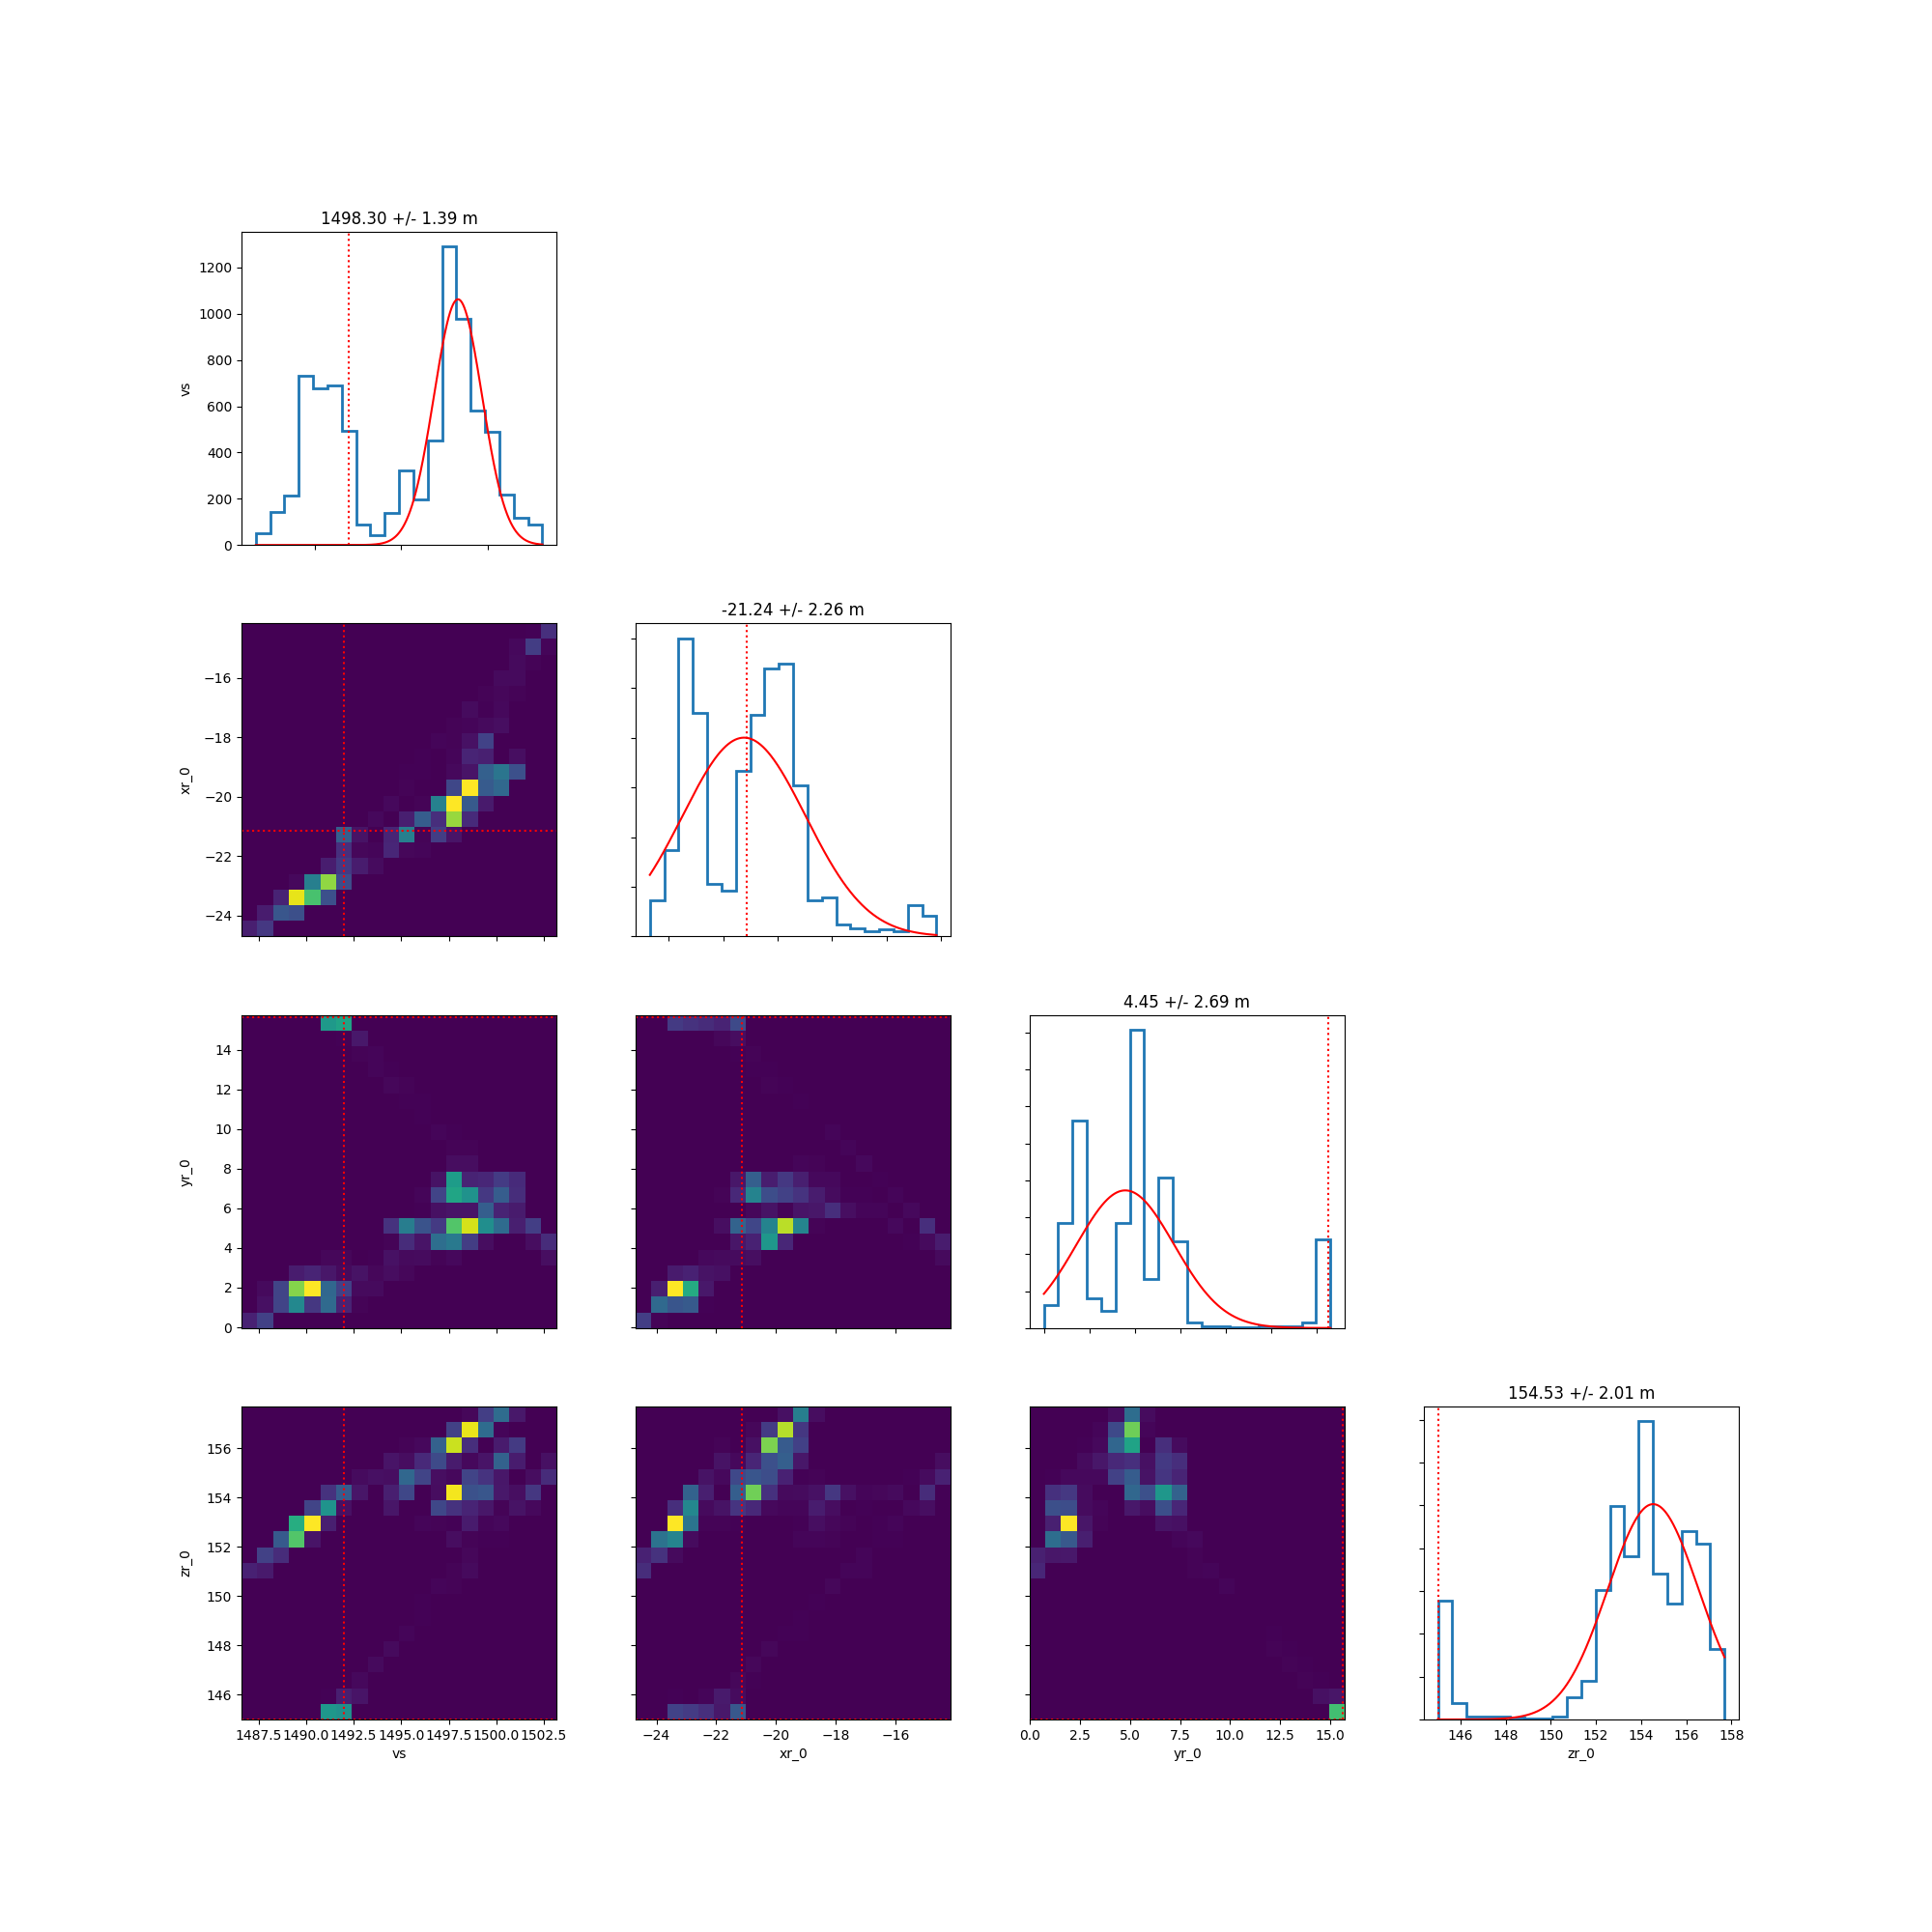

In [23]:
chain  = multiple_arrays(sample, var_names=['vs', 'xr'])
ndim   = chain.shape[1] 
bins   = 20
trth   = np.concatenate(([c0], X_R.flatten()))
lbls   = ['vs'] \
          + ['xr_%i' %(i) for i, rec in enumerate(X_R.flatten()[::3])]  \
          + ['yr_%i' %(i) for i, rec in enumerate(X_R.flatten()[1::3])] \
          + ['zr_%i' %(i) for i, rec in enumerate(X_R.flatten()[2::3])]

fs   = 20
fig  = plt.figure(figsize=(fs, fs))
gs   = fig.add_gridspec(ndim, ndim, hspace=0.25, wspace=0.25)

for i in range(ndim):
               
    for j in range(ndim):
        
        if j <= i:
            ax = fig.add_subplot(gs[i:i+1, j:j+1])
            
        # plot hist
        if i == j:
            # truths
            ax.axvline(trth[i], color='red', ls=':')
            # mcmc hist
            x    = chain[:,i]
            n, e = np.histogram(x, bins=bins)
            # fit
            xfit = np.linspace(x.min(), x.max(), 10000)
            popt = fit_gaussian(x, bins=bins, r=(x.min(), x.max()), sigma=1.1)
            # plot
            ax.stairs(n, e, lw=2)
            ax.plot(xfit, gaussian(xfit, *popt), color='red')
            # title
            ax.set_title('%.2f +/- %.2f m' %(popt[1], popt[2]))
            
        # plot scatter
        if i > j:
            # truths
            ax.scatter(trth[j], trth[i], marker='x', color='red')
            ax.axvline(trth[j], color='red', ls=':')
            ax.axhline(trth[i], color='red', ls=':')
            H, yedges, xedges = np.histogram2d(chain[:,i], chain[:,j], bins=bins
                                              )
            ax.pcolormesh(xedges, yedges, H)
            
        if i > 0 and j > 0:
            ax.tick_params(axis='y', which='both', labelleft=False)
            
        if i < ndim-1:
            ax.tick_params(axis='x', which='both', labelbottom=False) 
            
        if j == 0:
            ax.set_ylabel(lbls[i])
        
        if i == ndim-1:
            ax.set_xlabel(lbls[j])
            
fig.align_ylabels()
#plt.savefig("sonardyne_loc1.png")
plt.show()

---